In [1]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
import numpy as np
import hdbscan
import os.path

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
import pandas as pd
import os.path
FILEID = 1
FILEIDS = [1, 3, 36, 39, 49, 52]
LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
NUMERIC_COLUMNS = ['ts', 'orig_p', 'resp_p', "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration'] # integer columns

In [2]:
def convert_to_csv(FILEID):
    if not os.path.isfile(f'csv/capture{FILEID}_1.csv'):
        LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
        fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
                'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed_label']
        df = pd.read_csv(LOGFILE, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                        names=fieldsIN, header=None, engine='python')
        df = df.drop(['tunnel_parents'], axis=1)
        df.to_csv(f'csv/capture{FILEID}_1.csv')
        print(df.shape)
        for column in NUMERIC_COLUMNS:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        return df


In [3]:
df = pd.read_csv('csv/capture1_1.csv')


In [4]:
!head "csv/capture1_1.csv"

df.head(5)

df.isna().sum()

,ts,uid,orig_h,orig_p,resp_h,resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,detailed_label
0,1525879831.045045,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
1,1525879832.01624,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,0,S0,-,-,0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan
2,1525879832.024985,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
3,1525879832.044975,CMBrup3BLXivSp4Avc,192.168.100.103,50244,120.210.108.200,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan
4,1525879833.016171,CfHl9r3XMYtDQRrHnh,192.168.100.103,34243,147.7.65.203,49560,tcp,-,2.998804,0,0,S0,-,-,0,S,3,180,0,0,Benign,-
5,1525879833.044906,C7USrA15nFVkniMqC5,192.168.100.103,34840,145.164.35.6,212

Unnamed: 0        0
ts                0
uid               0
orig_h            0
orig_p            0
resp_h            0
resp_p            0
proto             0
service           0
duration          0
orig_bytes        0
resp_bytes        0
conn_state        0
local_orig        0
local_resp        0
missed_bytes      0
history           0
orig_pkts         0
orig_ip_bytes     0
resp_pkts         0
resp_ip_bytes     0
label             0
detailed_label    0
dtype: int64

In [5]:
def hdbscanner(df):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    df['category'] = pd.Series(labels)

    return df


In [6]:
    df1_ = df.loc[:, ['orig_p', 'resp_p']]
    df1 = hdbscanner(df1_)




In [7]:
df1.head(10)

,orig_p,resp_p,category
0,41101,23,46503
1,60905,23,22246
2,44301,23,39639
3,50244,23,28321
4,34243,49560,6030
5,34840,21288,5117
6,58525,23,25472
7,43849,8080,52515
8,40973,8080,-1
9,52259,23,27081


In [8]:
df1['category'].max()

91434

In [9]:
df1['category'].min()

-1

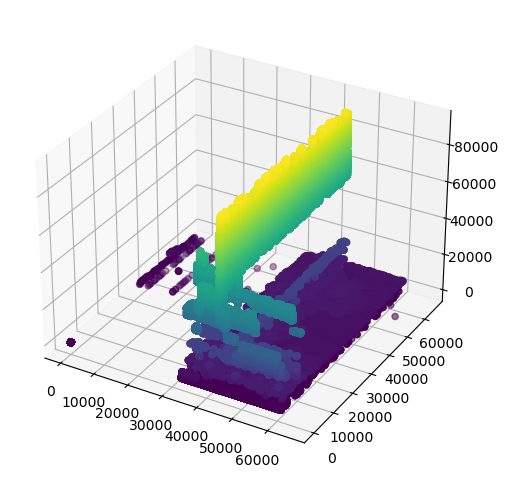

In [10]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection='3d')
#sc = ax.scatter(data=df1, x='orig_p', y='resp_p', z='category', s=40, c='category', marker='o', cmap='plasma', alpha=1)

ax.scatter3D(df1['orig_p'], df1['resp_p'], df1['category'], c=df1['category'])

plt.show()

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from seaborn import load_dataset, pairplot


In [12]:
X = df1[['orig_p', 'resp_p']]
y = df1['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


In [13]:
# The SVC Class from Sklearn
#clf = SVC(*,
#    C=1.0,                          # The regularization parameter
#    kernel='rbf',                   # The kernel type used 
#    degree=3,                       # Degree of polynomial function 
#    gamma='scale',                  # The kernel coefficient
#    coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
#    shrinking=True,                 # To use shrinking heuristic
#    probability=False,              # Enable probability estimates
#    tol=0.001,                      # Stopping crierion
#    cache_size=200,                 # Size of kernel cache
#    class_weight=None,              # The weight of each class
#    verbose=False,                  # Enable verbose output
#    max_iter=- 1,                   # Hard limit on iterations
#    decision_function_shape='ovr',  # One-vs-rest or one-vs-one
#    break_ties=False,               # How to handle breaking ties
#    random_state=None               # Random state of the model
#)

In [ ]:
# Building and training our model
clf = SVC(kernel='linear', verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

In [ ]:
# Visualizing the linear function for our SVM classifier
import numpy as np
from seaborn import scatterplot
w = clf.coef_[0]
b = clf.intercept_[0]
x_visual = np.linspace(0,60000)
y_visual = -(w[0] / w[1]) * x_visual - b / w[1]

scatterplot(data = X_train, x='orig_p', y='resp_p', hue=y_train)
plt.plot(x_visual, y_visual)
plt.show()